In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-08-01-01-01-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-01-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-07-02-01-02-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-07-01-01-02-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-02-01-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-06-02-02-01-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-04-01-02-01-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-02-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-02-01-01-02-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-03-01-01-01-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-07-01-02-02-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-05-01-01-02-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_0

# **SPEECH EMOTION RECOGNITION**


**TABLE OF CONTENTS**
* INTRODUCTION
* EXPLORATORY DATA ANALYSIS (EDA)
* DATA AUGMENTATION
* FEATURE EXTRACTION
* MODEL

# INTRODUCTION

**PROBLEM STATEMENT**

The purpose is to recognize the emotion and affective state of the speaker from his/her speech signal. 

**DATA SOURCE USED**

We have used the RAVDESS dataset in this project.It is one of the more common dataset used for this excercise by others. It's well liked because of its quality of speakers, recording and it has 24 actors of different genders.
Here's the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Here's an example of an audio filename. 02-01-06-01-02-01-12.mp4

# EXPLORATORY DATA ANALYSIS

The key features of the audio data are namely, MFCC (Mel Frequency Cepstral Coefficients) and Mel Spectrogram 

* MFCC (Mel Frequency Cepstral Coefficients)- 
MFCC is important feature extraction when using speech data,Mel scale is a scale that relates the perceived frequency of a tone to the real measured frequency. It scales the frequency so that you can fit greater carefully what the human ear can hear 



* Mel Spectrogram- 
A Fast Fourier Transform is computed on overlapping windowed segments of the signal, and what is the spectrogram , Spectrogram is visual way of representation of signal strength and also use for display the frequency sound waves.



For the EDA we have used MFCC and Mel Spectogram

In [2]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD



import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [3]:
# path to the directory
RAVD = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"

In [4]:
dirl_list = os.listdir(RAVD)
dirl_list.sort()

emotion = []
gender = []
path = []
for i in dirl_list:
    fname = os.listdir(RAVD + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAVD + i + '/' + f)

        
RAVD_df = pd.DataFrame(emotion)
RAVD_df = RAVD_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAVD_df = pd.concat([pd.DataFrame(gender),RAVD_df],axis=1)
RAVD_df.columns = ['gender','emotion']
RAVD_df['labels'] =RAVD_df.gender + '_' + RAVD_df.emotion
RAVD_df['source'] = 'RAVDESS'  
RAVD_df = pd.concat([RAVD_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAVD_df = RAVD_df.drop(['gender', 'emotion'], axis=1)
RAVD_df.labels.value_counts()

male_neutral       144
female_neutral     144
male_sad            96
male_fear           96
male_happy          96
male_disgust        96
male_angry          96
male_surprise       96
female_surprise     96
female_disgust      96
female_fear         96
female_sad          96
female_happy        96
female_angry        96
Name: labels, dtype: int64

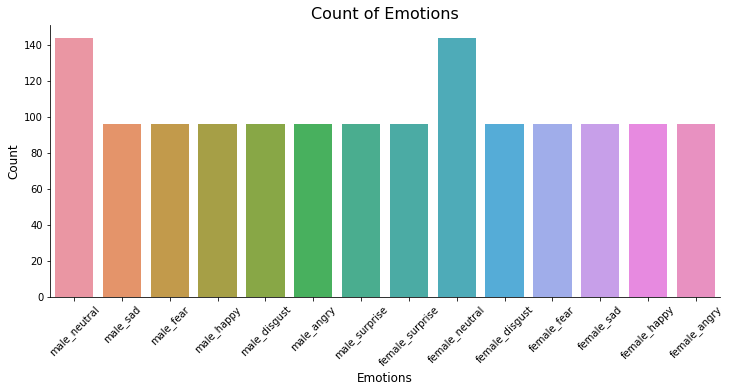

In [5]:
plt.figure(figsize=(12, 5))
plt.title('Count of Emotions', size=16)
sns.countplot(RAVD_df.labels)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.xticks(rotation=45)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()